In [1]:
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process import GaussianProcessRegressor
import random
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("library14_data.xlsx")

In [3]:
####### file from https://www.genome.jp/aaindex/ #########
aaindex = pd.read_csv("aaindex.csv", delimiter="\n")

target_string = aaindex.iloc[7].values

idxes = list(aaindex[aaindex.apply(
    lambda x:x.values in target_string, axis=1)].index)

sub_df = aaindex.iloc[idxes[3] + 1:idxes[3] + 3].values

aaindex_dict = {"A": [], "R": [], "N": [], "D": [], "C": [], "Q": [], "E": [], "G": [], "H": [], "I": [],
                "L": [], "K": [], "M": [], "F": [], "P": [], "S": [], "T": [], "W": [], "Y": [], "V": []}

nulls = 0

for idx in idxes:
    sub_df = aaindex.iloc[idx + 1:idx + 3].values

    counter = 0
    amino_acids = list(aaindex_dict.keys())

    for j in range(sub_df.shape[0]):
        temp_seq = sub_df[j][0].split(" ")
        for item in temp_seq:
            if len(item) >= 1:
                if item == "NA":
                    item = -999
                    nulls += 1
                aaindex_dict[amino_acids[counter]].append(float(item))
                counter += 1

aa_df = pd.DataFrame(aaindex_dict)

aa_df = aa_df.T

dropcols = []
for col in aa_df.columns:
    if (aa_df[col] == -999).sum() > 0:
        dropcols.append(col)


aa_df = aa_df[[x for x in aa_df.columns if x not in dropcols]]

idx = aa_df.index
scler = StandardScaler()
aa_df = scler.fit_transform(aa_df)

aa_df = pd.DataFrame(aa_df, index=idx)

for key in aaindex_dict.keys():
    aaindex_dict[key] = aa_df.loc[key].values

In [4]:
aa_df = pd.DataFrame({"As": list(aaindex_dict.keys()),
                     "c": list(aaindex_dict.values())})

pc = PCA(n_components=20)

pc = pc.fit_transform(np.stack(aa_df["c"]))

for i in range(pc.shape[1]):
    aa_df["f_"+str(i)] = pc[:, i]

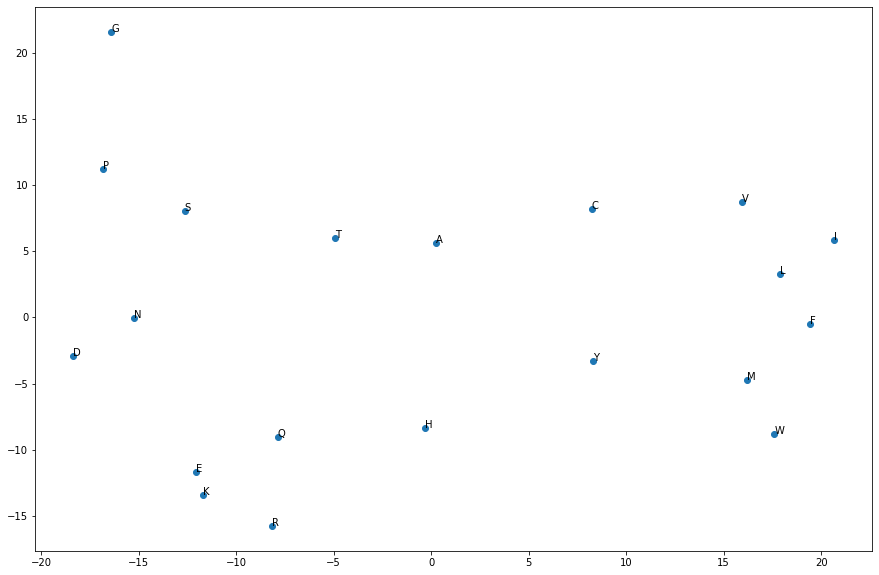

In [5]:
pc2 = PCA(n_components=2)
pc2 = pc2.fit_transform(pc)

plt.figure(figsize=(15, 10))
plt.scatter(pc2[:, 0], pc2[:, 1])


for i in range(pc2.shape[0]):
    plt.annotate(list(aaindex_dict.keys())[i], (pc2[i, 0], pc2[i, 1]))

In [6]:
aa_df = pd.DataFrame({"As": list(aaindex_dict.keys()),
                     "c": list(aaindex_dict.values())})

In [7]:
df2 = df.copy()
df2["variant"] = df2.apply(lambda x: x["L241"] + x["M242"] + x["Q245"], axis=1)

all_variants = [x + y + z for x in list(df2.L241.unique())
                for y in list(df2.L241.unique()) for z in list(df2.L241.unique())]

all_variants = [x for x in all_variants if x not in list(df2.variant)]
all_variants_df = pd.DataFrame({"variant": all_variants})

all_variants_df["L241"] = all_variants_df.apply(
    lambda x: x["variant"][0], axis=1)
all_variants_df["M242"] = all_variants_df.apply(
    lambda x: x["variant"][1], axis=1)
all_variants_df["Q245"] = all_variants_df.apply(
    lambda x: x["variant"][2], axis=1)


aa_df = pd.DataFrame({"As": list(aaindex_dict.keys()),
                     "c": list(aaindex_dict.values())})

pc = PCA(n_components=11)

pc = pc.fit_transform(np.stack(aa_df["c"]))

for i in range(pc.shape[1]):
    aa_df["f_"+str(i)] = pc[:, i]

aa_df.drop("c", axis=1, inplace=True)

t_scale = aa_df.copy()

for t in aa_df.columns[1:]:
    sclr = StandardScaler()
    t_scale[t] = sclr.fit_transform(np.array(t_scale[t]).reshape((-1, 1)))


def make_t_scale_df(df):

    cols = [x for x in df.columns if x not in ["target", "variant"]]

    for t, i in enumerate(cols):
        df = pd.merge(df, t_scale, how="left", left_on=i, right_on="As")
        df.drop("As", axis=1, inplace=True)
        keep_cols = aa_df.columns[1:]
        df.rename(columns={x: str(x) + "_" + str(t + 1)
                  for x in keep_cols}, inplace=True)
    df.drop(cols, axis=1, inplace=True)

    return df


data = make_t_scale_df(df)
all_variants_df = make_t_scale_df(all_variants_df)


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)


def gaussian_ei(X, model, y_opt=0.0, xi=0.01, return_grad=False):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        if return_grad:
            mu, std, mu_grad, std_grad = model.predict(
                X, return_std=True, return_mean_grad=True,
                return_std_grad=True)

        else:
            mu, std = model.predict(X, return_std=True)

    # check dimensionality of mu, std so we can divide them below
    if (mu.ndim != 1) or (std.ndim != 1):
        raise ValueError("mu and std are {}-dimensional and {}-dimensional, "
                         "however both must be 1-dimensional. Did you train "
                         "your model with an (N, 1) vector instead of an "
                         "(N,) vector?"
                         .format(mu.ndim, std.ndim))

    values = np.zeros_like(mu)
    mask = std > 0
    improve = y_opt - xi - mu[mask]
    scaled = improve / std[mask]
    cdf = norm.cdf(scaled)
    pdf = norm.pdf(scaled)
    exploit = improve * cdf
    explore = std[mask] * pdf
    values[mask] = exploit + explore

    if return_grad:
        if not np.all(mask):
            return values, np.zeros_like(std_grad)
        # Substitute (y_opt - xi - mu) / sigma = t and apply chain rule.
        # improve_grad is the gradient of t wrt x.
        improve_grad = -mu_grad * std - std_grad * improve
        improve_grad /= std ** 2
        cdf_grad = improve_grad * pdf
        pdf_grad = -improve * cdf_grad
        exploit_grad = -mu_grad * cdf - pdf_grad
        explore_grad = std_grad * pdf + pdf_grad

        grad = exploit_grad + explore_grad
        return values, grad

    return mu, values


def make_predictions(t_idx, v_idx):

    x_train, y_train = data.iloc[t_idx][features], data.iloc[t_idx][target]
    x_val, y_val = data.iloc[v_idx][features], data.iloc[v_idx][target]

    y_train = y_train * - 1
    y_val = y_val * -1

    kernel = Matern(length_scale=1., nu=1.5)
    lreg = GaussianProcessRegressor(kernel)

    lreg.fit(x_train, y_train)

    yhat, expected_improvement = gaussian_ei(
        x_val, lreg, y_train.min(), return_grad=False)

    yhat_pred, expected_improvement_pred = gaussian_ei(
        all_variants_df[features], lreg, y_train.min(), return_grad=False)

    yhat = lreg.predict(x_val)
    #expected_improvement = np.zeros(len(yhat))

    yhat_pred = lreg.predict(all_variants_df[features])
    #expected_improvement_pred = np.zeros(len(yhat_pred))

    yhat = np.expm1((yhat * -1).clip(0, 10))

    yhat_pred = np.expm1((yhat_pred * -1).clip(0, 10))

    y_train = y_train * -1
    y_val = y_val * -1

    r2 = r2_score(np.expm1(y_val), yhat)
    mse = mean_squared_error(np.expm1(y_val), yhat)

    gc.collect()

    return {"r2": r2, "mse": mse, "yhat": yhat, "ei": expected_improvement, "yhat_pred": yhat_pred,
            "ei_pred": expected_improvement_pred}


features = list(data.columns[1:])
target = "target"

data["target"] = np.log1p(data["target"])

n_splits = 10

cv = KFold(n_splits=n_splits)
oof_pred = np.zeros(len(data))
oof_ei = np.zeros(len(data))

oof_all_as_pred = np.zeros(len(all_variants_df))
oof_all_as_ei = np.zeros(len(all_variants_df))

for t, (train_idx, val_idx) in enumerate(cv.split(data)):

    r = make_predictions(train_idx, val_idx)

    print(r["r2"])

    oof_pred[val_idx] = r["yhat"]
    oof_ei[val_idx] = r["ei"]

    oof_all_as_pred += (r["yhat_pred"] / n_splits)
    oof_all_as_ei += (r["ei_pred"] / n_splits)

print(f"final r2: {r2_score(np.expm1(data.target),oof_pred)}")
print(f"final mse: {mean_squared_error(np.expm1(data.target),oof_pred)}")


valid_df = pd.DataFrame({"target": np.expm1(data.target), "variant": df.apply(
    lambda x: x["L241"] + x["M242"] + x["Q245"], axis=1), "ei": oof_ei, "pred": oof_pred})
valid_df = valid_df.sort_values("ei", ascending=False).reset_index(drop=True)
print("*" * 10, valid_df.loc[valid_df.variant == "LPQ"].index, "*" * 10)

all_variants_df["ei"] = oof_all_as_ei
all_variants_df["pred"] = oof_all_as_pred
all_variants_df[["variant", "ei", "pred"]].sort_values(
    "pred", ascending=False)[:15].reset_index(drop=True)

0.5644246313001196
0.6645354645122501
0.7762698946347621
0.6924802607758342
0.6267549212987955
0.7484050596430822
0.4989154823297477
0.5947607650100388
0.682072400118926
0.7049504437763298
final r2: 0.6615080806824104
final mse: 0.06659884569013251
********** Int64Index([], dtype='int64') **********


,variant,ei,pred
0,TWT,0.184019,4.725879
1,VWT,0.171377,4.684221
2,SWT,0.158685,4.569734
3,IWT,0.109161,4.238430
4,CWT,0.087085,4.110677
5,YWT,0.068471,3.987065
6,AWT,0.068839,3.882506
7,QWT,0.052819,3.721288
8,FWT,0.048769,3.701050
9,TWS,0.043809,3.629916


In [8]:
all_variants_df = all_variants_df[["variant", "pred"]].sort_values(
    "pred", ascending=False)
all_variants_df.reset_index(drop=True, inplace=True)

all_variants_df.to_excel("lib_14_predictions.xlsx", index=False)

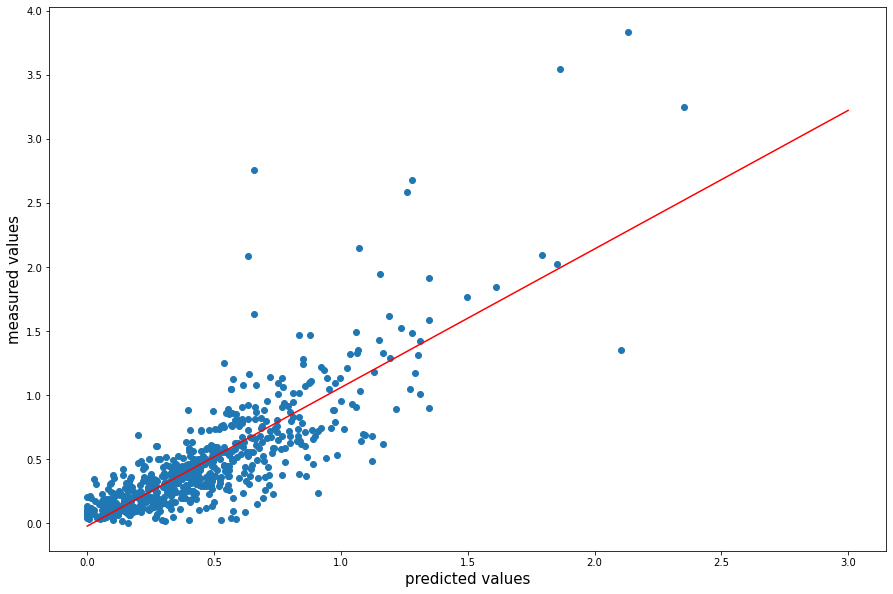

In [9]:
lreg = LinearRegression()

lreg.fit(oof_pred.reshape(-1, 1), np.expm1(data.target).values.reshape(-1, 1))

x = np.linspace(0, 3, 300).reshape(-1, 1)
y = lreg.predict(x)

plt.figure(figsize=(15, 10))
plt.scatter(oof_pred, np.expm1(data.target))
plt.xlabel("predicted values", fontsize=15)
plt.ylabel("measured values", fontsize=15)
plt.plot(x, y, c="r")
plt.savefig("lib14.png")